In [1]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
from six.moves import xrange

from tflib.save_images import *

In [2]:
data_dir = '../GAN-CS/dcgan-completion.tensorflow/data/celeba'
import helper

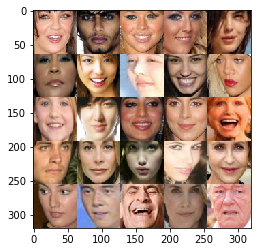

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
face_images = helper.get_batch(glob(os.path.join(data_dir, 'aligned/*.png'))[:show_n_images], 64, 64, 'RGB')
pyplot.imshow(helper.images_square_grid(face_images, 'RGB'))

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

"""
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
"""

"\n# Check TensorFlow Version\nassert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)\nprint('TensorFlow Version: {}'.format(tf.__version__))\n\n# Check for a GPU\nif not tf.test.gpu_device_name():\n    warnings.warn('No GPU found. Please use a GPU to train your neural network.')\nelse:\n    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))\n"

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_imgs = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_real')
    fake_imgs = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_fake')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_imgs, fake_imgs,inputs_z, learning_rate

In [6]:
HIDDEN_DIM = 64
INPUT_DIM = 64 * 64 * 3
IMAGE_SHAPE = [64, 64, 3]

## Encoder

In [30]:
def encoder(images, z_dim, leaky_factor=0.2, name='encoder', reuse=False):
    """
    Create the encoder network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :leaky_factor: leaky_factor for leaky relu layer
    :return: Tensor of output vector (latent z )
    """
    with tf.variable_scope(name, reuse=reuse):
        # conv2d
        x1 = tf.layers.conv2d(images, HIDDEN_DIM, 5, strides=2, padding='same')
        relu1 = tf.maximum(leaky_factor * x1, x1)
        # 32 * 32 * 64
        
        x2 = tf.layers.conv2d(relu1, HIDDEN_DIM * 2, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 16 * 16 * 128
        
        x3 = tf.layers.conv2d(relu2, HIDDEN_DIM * 4, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 8 * 8 * 256
        
        x4 = tf.layers.conv2d(relu3, HIDDEN_DIM * 8, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(0.2 * bn4, bn4)
        # 4 * 4 * 512
        
        flat = tf.contrib.layers.flatten(relu4)
        z = tf.layers.dense(flat, z_dim)

        return z

## Simple_Encoder

In [8]:
def simple_encoder(images, z_dim, leaky_factor=0.2, name='encoder', reuse=False):
    """
    Create the encoder network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :leaky_factor: leaky_factor for leaky relu layer
    :return: Tensor of output vector (latent z )
    """
    with tf.variable_scope(name, reuse=reuse):

        # Flatten it
        #norm = tf.random_normal_initializer(stddev=0.01)
        x1 = tf.contrib.layers.flatten(images)
        x1 = tf.layers.dense(x1, 1024)
        x1 = tf.layers.batch_normalization(x1, training=(not reuse))
        relu1 = tf.maximum(leaky_factor * x1, x1)
        #relu1 = tf.nn.relu(x1)
        
        x2 = tf.layers.dense(relu1, 1024)
        x2 = tf.layers.batch_normalization(x2, training=(not reuse))
        relu2 = tf.maximum(leaky_factor * x2, x2)
        #relu2 = tf.nn.relu(x2)
        
        out = tf.layers.dense(relu2, z_dim)
        #out = tf.maximum(leaky_factor * out, out)
        return out

## Decoder

In [31]:

def decoder(z, out_channel_dim, leaky_factor=0.2, name='decoder',is_train=True):
    """
    Create the decoder network
    :param images: Tensor of input z
    :param out_channel_dim: the output channel format
    :param leaky_factor: leaky_factor for leaky relu layer
    :param is_train: Boolean if it is train mode or test mode
    :return: Tensor of output vector (latent z )
    """
    with tf.variable_scope(name, reuse= (not is_train)):
        x1 = tf.layers.dense(z, 4 * 4* HIDDEN_DIM * 8)
        x1 = tf.reshape(x1, [-1, 4, 4, HIDDEN_DIM * 8])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        #relu1 = tf.maximum(leaky_factor * x1, x1)
        relu1 = tf.nn.relu(x1)
        # 4 * 4 * 512
        
        x2 = tf.layers.conv2d_transpose(relu1, HIDDEN_DIM * 4, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        #x3 = tf.maximum(0.2 * x3, x3)
        relu2 = tf.nn.relu(x2)
        # 8 * 8 * 256
        
        x3 = tf.layers.conv2d_transpose(relu2, HIDDEN_DIM * 2, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(0.2 * x3, x3)
        relu3 = tf.nn.relu(x3)
        # 16 * 16 * 128
        
        
        x4 = tf.layers.conv2d_transpose(relu3, HIDDEN_DIM, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x3 = tf.maximum(0.2 * x3, x3)
        relu4 = tf.nn.relu(x4)
        # 32 * 32 * 64
        
        logits = tf.layers.conv2d_transpose(relu4, 3, 5, strides=2, padding='same')
        # 64 * 64 * 3
        out = tf.tanh(logits)
        return out

## Simple_Decoder

In [10]:
"""
def decoder(z, out_channel_dim, leaky_factor=0.2, name='decoder',is_train=True):
    """
    Create the decoder network
    :param images: Tensor of input z
    :param out_channel_dim: the output channel format
    :param leaky_factor: leaky_factor for leaky relu layer
    :param is_train: Boolean if it is train mode or test mode
    :return: Tensor of output vector (latent z )
    """    
    with tf.variable_scope(name, reuse= (not is_train)):
        x1 = tf.layers.dense(z, 1024)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(leaky_factor * x1, x1)
        #relu1 = tf.nn.relu(x1)
        
        x2 = tf.layers.dense(relu1, 1024)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(leaky_factor * x2, x2)
        #relu2 = tf.nn.relu(x2)
        
        #out = tf.tanh(tf.layers.dense(relu2, INPUT_DIM))
        out = tf.tanh(tf.layers.dense(relu2, INPUT_DIM))
        return tf.reshape(out, [-1] + IMAGE_SHAPE)
"""

## Discriminator

In [32]:
def discriminator(input_z, leaky_factor=0.2, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input z
    :param leaky_factor: leaky_factor for leaky relu layer
    :param reuse: Boolean if it is train mode or test mode
    :return: tuple of (classification result, logits)
    """    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.dense(input_z, 2*4*4 * HIDDEN_DIM)
        x1 = tf.layers.batch_normalization(x1, training=(not reuse))
        relu1 = tf.maximum(leaky_factor * x1, x1)

        x2 = tf.layers.dense(relu1, 2*4*4 * HIDDEN_DIM)
        x2 = tf.layers.batch_normalization(x2, training=(not reuse))
        relu2 = tf.maximum(leaky_factor * x2, x2)

        logits = tf.layers.dense(x2, 1)
        out = tf.sigmoid(logits)

        return out, logits

## Corruptor

In [12]:
def corrupt(images, mask_type='inpainting',noise=False):
    """
    Create the discriminator network
    :param images: Tensor of input images
    :param noise: Boolean if gaussian noise will be added
    :return: Tensor of corrupted images
    """ 
    image_shape = images.get_shape().as_list()[1:]
    x, y, z = image_shape
    length_input = x * y * z
    mu = 0.0
    sigma = 0.5
    gnoise = np.random.normal(loc=mu, scale=sigma, size=image_shape)
    if noise:
        images = tf.add(images, gnoise)
        
    if mask_type == 'inpainting':
        # inpainting 
        a, b = 2, 2
        pixFrac = np.random.beta(a,b)
        #pixFrac = 0.5
        mask = np.random.binomial(1, pixFrac, image_shape)
        result = tf.multiply(images, mask)
        return result
    elif mask_type == 'compress':
        # compressive sensing
        flat_images = tf.contrib.layers.flatten(images)
        #A = np.random.normal(loc=mu, scale=sigma,size=[length_input//5, length_input])
        #A = np.array(A, dtype=np.float32)
        #mask = np.matmul(A.transpose(), A)
        A = tf.random_normal([length_input // 5, length_input], name='sensing_matrix')
        mask = tf.matmul(tf.transpose(A), A)
        result = tf.matmul(flat_images, mask)
        return tf.reshape(result, [-1] + image_shape)
    else:
        return images
    
    
def corrupt_func(images, mask_type='inpainting',noise=True):
    """
    Create the discriminator network
    :param images: Tensor of input images
    :param noise: Boolean if gaussian noise will be added
    :return: Tensor of corrupted images
    """ 
    image_shape = images.shape[1:]
    x, y, z = image_shape
    length_input = x * y * z
    mu = 0.0
    sigma = 0.5
    gnoise = np.random.normal(loc=mu, scale=sigma, size=image_shape)
    result = np.zeros(images.shape)
    result += images
    if noise:
        result += gnoise
        
    if mask_type == 'inpainting':
        # inpainting 
        #a, b = 2, 2
        #pixFrac = np.random.beta(a,b)
        pixFrac = 0.2
        mask = np.random.binomial(1, pixFrac, image_shape)
        result = np.multiply(result, mask)
        return result
    elif mask_type == 'compress':
        # compressive sensing
        flat_images = np.array(list(map(lambda x: x.flatten(), result)))
        
        A = np.random.normal(loc=mu, scale=sigma,size=[length_input//5, length_input])
        A = np.array(A, dtype=np.float32)
        mask = np.matmul(A.transpose(), A)
        #A = tf.random_normal([length_input // 5, length_input], name='sensing_matrix')
        #mask = tf.matmul(tf.transpose(A), A)
        #result = tf.matmul(flat_images, mask)
        result = np.array(list(map(lambda x : np.matmul(x, mask), flat_images)))
        return result.reshape(images.shape)
    else:
        return result

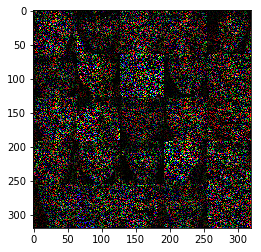

In [13]:
# test corrupt_func
A = corrupt_func(face_images, mask_type='inpainting', noise=False)
pyplot.imshow(helper.images_square_grid(A, 'RGB'))

### Loss
Implement `model_loss` to build the DAAE for training and calculate the loss.  The function should return a tuple of (discriminator loss, encoder loss, encoder-decoder loss).  Use the following functions you implemented:
- `discriminator(input_z, leaky_factor, reuse=False)`
- `decoder(z, out_channel_dim, leaky_factor, is_train=True)`
- `encoder(images, z_dim, leaky_factor, reuse=False)`

In [39]:
def model_loss(input_real, input_fake, input_z, z_dim, output_channel_dim):
    """
    Get the loss for the discriminator, encoder and decoder
    :param input_real: Images from the real dataset
    :param input_z: Z input from Laplacian distribution
    :param out_channel_dim: The number of channels in the output image
    :param M : how many iterations to sample from p(z|x)
    :return: A tuple of (discriminator loss, encoder loss, recon loss, dis_loss_sum, en_loss_sum, recon_loss_sum)
    """
    
    En = encoder(input_real, z_dim, name='en_real')
    De = decoder(En, output_channel_dim, name='decoder')
    
    #En = simple_encoder(input_real, z_dim, name='en_real')
    #De = decoder(En, output_channel_dim, name='decoder')
    
    recon_loss = tf.reduce_mean(tf.square(tf.subtract(De, input_real)))
    
    """
    recon_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=De,
                labels=input_real))
    """
    
        
    d_out_real, d_logits_real = discriminator(En)  
    

    #encorr = encoder(corr_images, z_dim, name='en_fake')
    encorr = encoder(input_fake, z_dim, name='en_fake')
    reconstruction = decoder(encorr, output_channel_dim, is_train=False)
    
    en_recon_loss = tf.reduce_mean(tf.square(tf.subtract(reconstruction, input_real)))
    
    
    d_out_fake, d_logits_fake = discriminator(encorr, reuse=True)

        
    d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.zeros_like(d_out_fake)))

    d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_real,
                labels=tf.ones_like(d_out_real)))

    dis_loss = d_loss_fake + d_loss_real
    
    
    temp_en_loss_dis = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.ones_like(d_out_fake)))
    
    temp_en_loss = tf.reduce_mean(tf.square(tf.subtract(En, encorr)))
    
    en_loss = 0 * temp_en_loss_dis + temp_en_loss + en_recon_loss
    
    
    temp_en_loss_sum = tf.summary.histogram("temp_en_loss_dis", temp_en_loss_dis)
    dis_loss_sum = tf.summary.scalar("dis_loss", dis_loss)
    recon_loss_sum = tf.summary.scalar("recon_loss", recon_loss)
    en_loss_sum = tf.summary.scalar("en_loss", en_loss)
    
    return dis_loss, en_loss, temp_en_loss_dis, recon_loss, dis_loss_sum,en_loss_sum, recon_loss_sum,reconstruction,De
    

In [41]:
def model_opt(dis_loss, en_loss, recon_loss, learning_rate, beta1, beta2):
    """
    Get optimization operations
    :param dis_loss: Discriminator loss Tensor
    :param en_loss: encoder loss Tensor
    :param recon_loss: reconstruction loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, encoder training operation, recontraining operations)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    dis_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    de_vars = [var for var in t_vars if var.name.startswith('decoder')]
    en_real_vars = [var for var in t_vars if var.name.startswith('en_real')]
    en_fake_vars = [var for var in t_vars if var.name.startswith('en_fake')]
    ed_vars = de_vars + en_real_vars
    
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='decoder')):
    ed_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(recon_loss, var_list=ed_vars)
    de_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(recon_loss, var_list=de_vars)
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(dis_loss, var_list=dis_vars)
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='encoder')):
    en_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(en_loss, var_list=en_fake_vars)
    
    return d_train_opt, en_train_opt, ed_train_opt, de_train_opt






## Training

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import scipy.stats as stats
from skimage.measure import compare_psnr

from scipy.stats import sem
def mean_score(scores):
    return ("##### What? The Mean score: {0:.3f} (+/-{1: .3f})").format(np.mean(scores), sem(scores))


def sample_from_dis(n_images, z_dim,dis = 'laplacian'):
    if dis == 'laplacian':
        mu = 0.0
        lam = 1.0
        return np.random.laplace(loc=mu, scale=lam, size=[n_images, z_dim])
    elif dis == 'gaussian':
        mu = 0
        lower = -1
        upper = 1
        sigma = 1 / np.sqrt(z_dim)
        sigma = 1
        z = stats.truncnorm.rvs((lower-mu)/sigma, (upper-mu)/sigma, loc=mu, scale=sigma, size=[n_images,z_dim])
        return z
    else:
        return np.random.uniform(-1, 1, size=[n_images, z_dim])


def show_decoder_output(sess, n_images, input_z, out_channel_dim, image_mode, distribution='laplacian'):
    """
    Show example output for the decoder
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
        
    example_z = sample_from_dis(n_images, z_dim, dis=None)

    samples = sess.run(
        decoder(input_z, out_channel_dim, leaky_factor=0.2, is_train = False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    
def show_endecoder_output(sess, samples, corrupt_samples, recon_samples,input_z, out_channel_dim, image_mode, distribution='laplacian'):
    """
    Show example output for the encoder-decoder
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
        
    #example_z = sample_from_dis(n_images, z_dim, dis=distribution)
    #corrupt_images = corrupt_func(sample_images, mask_type='inpainting', noise=False)
    
    #ops = [reconstruction]
    
    #samples = sess.run(
    #    ops,
    #    feed_dict={'input_fake': corrupt_images})
    
    #mse = np.mean((samples - recon_samples) ** 2)
    #print("######### what? the reconstruction mse is: %2.4f"  % mse)

    psnr = compare_psnr(samples, recon_samples)
    print("######### what? the reconstruction psnr is: %2.4f"  % psnr)
    
    images_grid = helper.images_square_grid(recon_samples, image_mode)
    corr_grid = helper.images_square_grid(corrupt_samples, image_mode)
    
    pyplot.subplot(121)
    pyplot.imshow(corr_grid, cmap=cmap)
    
    pyplot.subplot(122)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    

## run

In [43]:
import time

checkpoint_dir = './UIUC_plus_checkpoint'
model_name = "AntiUIUCplus.model"
mask_t = 'inpainting'
NOISE = False

def save(saver, sess, checkpoint_dir, model_name, steps):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,os.path.join(checkpoint_dir, model_name),
                        global_step=steps)

    
def load(saver, sess, checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        return True
    else:
        return False



def train(epoch_count, batch_size, z_dim, learning_rate, beta1, beta2, M, get_batches, samples, data_shape, data_image_mode):
    """
    Train the DAAE
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :param M: iterations to sample fake_z
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    num_imgs, image_width, image_height, image_channels = data_shape
    
    input_real, input_fake,input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    #tf.assign(lr, learning_rate)
    output_channel_dim = image_channels
    
    result = model_loss(input_real, input_fake,input_z, z_dim, output_channel_dim)
    dis_loss, en_loss, temp_en_loss_dis, recon_loss, dis_loss_sum, en_loss_sum, recon_loss_sum,reconstruction,De = result
    
    d_train_opt, en_train_opt, ed_train_opt, de_train_opt = model_opt(dis_loss, en_loss, recon_loss, learning_rate, beta1,beta2)
    ITER = 1 # we can train en-decoder more than 1 time...later~
    steps = 0
    
    recon_sum = tf.summary.merge([recon_loss_sum])
    en_sum = tf.summary.merge([en_loss_sum])
    dis_sum = tf.summary.merge([dis_loss_sum])

    saver = tf.train.Saver(max_to_keep=1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter("./logs", sess.graph)
        
        # check if already exists a model
        if load(saver, sess, checkpoint_dir):
            print("""
            We found a existing model and continue to train on it! 
            If you need a new model, delete checkpoint directory""")
        else:
            print("""NOT found a model === Initializing a new one""")
            
        #temp_en_val = 0.5
        dis_val = 0.5
        recon_val = 0.055
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_imgs = batch_images * 2
                #batch_imgs = batch_images + 0.5
                batch_z = sample_from_dis(batch_size, z_dim,dis = '')
 
                # Run optimizers

                # Update real_EnDecoder network
                #for i in range(ITER):
                if epoch_i < 2:
                    sess.run([ed_train_opt, recon_sum],
                            feed_dict={ input_real: batch_imgs})
                else:
                    _, summary_str = sess.run([de_train_opt, recon_sum],
                            feed_dict={ input_real: batch_imgs})
                    writer.add_summary(summary_str, steps)
                    
                """    
                if recon_val >= 0.055:
                    _, summary_str = sess.run([de_train_opt, recon_sum],
                            feed_dict={ input_real: batch_imgs})
                writer.add_summary(summary_str, steps)
                """
                
                
                # Update Discriminator and fake_Encoder
                
                for i in range(M):
                    
                    batch_fake = corrupt_func(batch_imgs, mask_type=mask_t, noise=NOISE)
                    # Update Discriminator network    
                    if dis_val >= 0.5:
                        _, summary_str = sess.run([d_train_opt, dis_sum],
                            feed_dict={ input_real: batch_imgs, input_fake:batch_fake,input_z: batch_z })
                        writer.add_summary(summary_str, steps)
                
                    # Update the fake_Encoder network
                    for j in range(ITER):
                        _, summary_str = sess.run([en_train_opt, en_sum],
                            feed_dict={input_real:batch_imgs, input_fake:batch_fake})
                    writer.add_summary(summary_str, steps)
               
            
                if steps % 10 == 0:
                    ops = [dis_loss, en_loss, temp_en_loss_dis, recon_loss]
                    dis_val,en_val,temp_en_val, recon_val= sess.run(ops, feed_dict={input_real:batch_images, input_z:batch_z,input_fake:batch_fake})
                    print("EPO: %d, dis_loss: %.5f, en_loss: %.5f, temp_en_dis: %.5f recon_loss: %2.4f" % (epoch_i, dis_val, en_val, temp_en_val,recon_val))
                    
                if steps % 100 == 0:
                    #show_decoder_output(sess, show_n_images, input_z, output_channel_dim, data_image_mode)
                    corrupt_samples = corrupt_func(samples, mask_type=mask_t, noise=NOISE)
                    recon_samples = sess.run(reconstruction, feed_dict={input_fake:corrupt_samples})
                    show_endecoder_output(sess, samples,corrupt_samples,recon_samples,input_z, output_channel_dim, data_image_mode)
                    
                if steps % 500 == 0:
                    save(saver, sess, checkpoint_dir, model_name, steps)
                    
                    

## Test!

In [44]:
from save_images import saveImg
sample_dir = './savedSamples'
def test(batch_size, z_dim, learning_rate, beta1, beta2, mask, get_batches, data_shape, data_image_mode):
    """
    test the model
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    num_imgs, image_width, image_height, image_channels = data_shape
    
    input_real, input_fake,input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    #tf.assign(lr, learning_rate)
    output_channel_dim = image_channels
    
    result = model_loss(input_real, input_fake,input_z, z_dim, output_channel_dim)
    dis_loss, en_loss, temp_en_loss_dis, recon_loss, dis_loss_sum, en_loss_sum, recon_loss_sum,reconstruction,De = result
    
    d_train_opt, en_train_opt, de_train_opt = model_opt(dis_loss, en_loss, recon_loss, learning_rate, beta1,beta2)
    ITER = 1 # we can train en-decoder more than 1 time...later~
    steps = 0
    

    saver = tf.train.Saver(max_to_keep=1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter("./logs", sess.graph)
        
        # check if already exists a model
        if load(saver, sess, checkpoint_dir):
            print("""
            We found a existing model and continue to train on it! 
            If you need a new model, delete checkpoint directory""")
        else:
            print("""NOT found a model === Initializing a new one""")
            return
 
        result = list()
        extra_result = list()
        for batch_images in get_batches(batch_size):
            # TODO: Train Model
            steps += 1
            batch_imgs = batch_images * 2
            #for j in range(batch_imgs.shape[0]):
            #    saveImg(batch_imgs[j], sample_dir + '/trueimgs/original_%d.png' % j)
            
            corrupt_imgs = np.multiply(batch_imgs, mask)
            recon_samples = sess.run(reconstruction, feed_dict={input_fake:corrupt_imgs})
            
            #for j in range(recon_samples.shape[0]):
            #    saveImg(recon_samples[j], sample_dir + '/reconimgs/recon_%d.png' % j)
            psnr = compare_psnr(batch_imgs, recon_samples)
            result.append(psnr)
            
            decoded_imgs = sess.run(De, feed_dict={input_real: batch_imgs})
            extra_psnr = compare_psnr(batch_imgs, decoded_imgs)
            extra_result.append(extra_psnr)
            print("Some psnr value is : %2.4f" % (extra_psnr))
            images_grid = helper.images_square_grid(batch_imgs, data_image_mode)
            de_grid = helper.images_square_grid(decoded_imgs, data_image_mode)
            
            pyplot.subplot(121)
            pyplot.imshow(de_grid, cmap=None)
    
            pyplot.subplot(122)
            pyplot.imshow(images_grid, cmap=None)
            pyplot.show()
        
        avg_psnr = sum(result) * 1.0 / len(result)
        avg_extra_psnr = sum(extra_result) * 1.0 / len(extra_result)
        print("Testing on validation set average psnr: %2.4f" % avg_psnr)
        print("Testing on original set average psnr: %2.4f" % avg_extra_psnr)
        return result



## Faces

(10000, 64, 64, 3)
 [*] Reading checkpoints...
NOT found a model === Initializing a new one
EPO: 0, dis_loss: 0.48463, en_loss: 0.24412, temp_en_dis: 10.45334 recon_loss: 0.0643
EPO: 0, dis_loss: 1.11490, en_loss: 0.15627, temp_en_dis: 11.58337 recon_loss: 0.0590
EPO: 0, dis_loss: 0.35772, en_loss: 0.15707, temp_en_dis: 14.86073 recon_loss: 0.0528
EPO: 0, dis_loss: 0.43345, en_loss: 0.17105, temp_en_dis: 15.01583 recon_loss: 0.0625
EPO: 0, dis_loss: 0.37361, en_loss: 0.14057, temp_en_dis: 14.30808 recon_loss: 0.0588
EPO: 0, dis_loss: 0.36963, en_loss: 0.13819, temp_en_dis: 14.46288 recon_loss: 0.0716
EPO: 0, dis_loss: 0.45095, en_loss: 0.13672, temp_en_dis: 14.47443 recon_loss: 0.0602
EPO: 0, dis_loss: 0.52638, en_loss: 0.13938, temp_en_dis: 13.29851 recon_loss: 0.0639
EPO: 0, dis_loss: 0.22930, en_loss: 0.12597, temp_en_dis: 13.48966 recon_loss: 0.0649
EPO: 0, dis_loss: 0.24073, en_loss: 0.14439, temp_en_dis: 14.44491 recon_loss: 0.0564
######### what? the reconstruction psnr is: 12.9

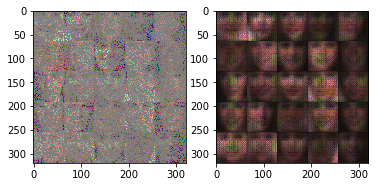

EPO: 0, dis_loss: 0.21633, en_loss: 0.13339, temp_en_dis: 13.28332 recon_loss: 0.0606
EPO: 0, dis_loss: 0.21295, en_loss: 0.15773, temp_en_dis: 13.59213 recon_loss: 0.0670
EPO: 0, dis_loss: 0.23364, en_loss: 0.15438, temp_en_dis: 13.77015 recon_loss: 0.0648
EPO: 0, dis_loss: 0.22993, en_loss: 0.17396, temp_en_dis: 13.40279 recon_loss: 0.0600
EPO: 0, dis_loss: 0.26275, en_loss: 0.15126, temp_en_dis: 13.47084 recon_loss: 0.0597
EPO: 0, dis_loss: 0.23819, en_loss: 0.20097, temp_en_dis: 12.36104 recon_loss: 0.0552
EPO: 0, dis_loss: 0.23763, en_loss: 0.17425, temp_en_dis: 12.64504 recon_loss: 0.0561
EPO: 0, dis_loss: 0.30667, en_loss: 0.17553, temp_en_dis: 12.20963 recon_loss: 0.0582
EPO: 0, dis_loss: 0.26209, en_loss: 0.16624, temp_en_dis: 11.10398 recon_loss: 0.0616
EPO: 0, dis_loss: 0.22418, en_loss: 0.19042, temp_en_dis: 11.47616 recon_loss: 0.0568
######### what? the reconstruction psnr is: 13.2439


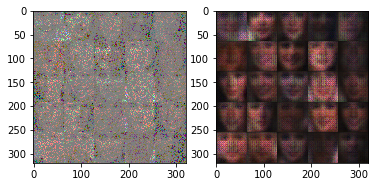

EPO: 0, dis_loss: 0.25733, en_loss: 0.19673, temp_en_dis: 10.91137 recon_loss: 0.0654
EPO: 0, dis_loss: 0.32706, en_loss: 0.16611, temp_en_dis: 11.63232 recon_loss: 0.0598
EPO: 0, dis_loss: 0.26922, en_loss: 0.19890, temp_en_dis: 11.21422 recon_loss: 0.0652
EPO: 0, dis_loss: 0.26916, en_loss: 0.20233, temp_en_dis: 11.00999 recon_loss: 0.0599
EPO: 0, dis_loss: 0.27142, en_loss: 0.17418, temp_en_dis: 10.68157 recon_loss: 0.0659
EPO: 0, dis_loss: 0.26694, en_loss: 0.21252, temp_en_dis: 10.40899 recon_loss: 0.0610
EPO: 0, dis_loss: 0.30884, en_loss: 0.21215, temp_en_dis: 10.77302 recon_loss: 0.0626
EPO: 0, dis_loss: 0.31260, en_loss: 0.20630, temp_en_dis: 11.11637 recon_loss: 0.0580
EPO: 0, dis_loss: 0.27604, en_loss: 0.21624, temp_en_dis: 10.37751 recon_loss: 0.0594
EPO: 0, dis_loss: 0.32341, en_loss: 0.19839, temp_en_dis: 10.35038 recon_loss: 0.0595
######### what? the reconstruction psnr is: 13.4083


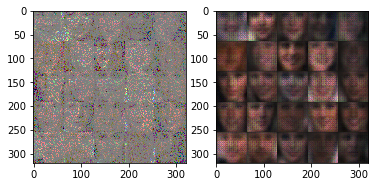

EPO: 0, dis_loss: 0.27126, en_loss: 0.21353, temp_en_dis: 10.31480 recon_loss: 0.0560
EPO: 1, dis_loss: 0.36005, en_loss: 0.19095, temp_en_dis: 10.79344 recon_loss: 0.0612
EPO: 1, dis_loss: 0.37478, en_loss: 0.20409, temp_en_dis: 10.03134 recon_loss: 0.0567
EPO: 1, dis_loss: 0.27977, en_loss: 0.21607, temp_en_dis: 10.53560 recon_loss: 0.0603
EPO: 1, dis_loss: 0.28568, en_loss: 0.21672, temp_en_dis: 10.26932 recon_loss: 0.0590
EPO: 1, dis_loss: 0.31397, en_loss: 0.18447, temp_en_dis: 10.60104 recon_loss: 0.0587
EPO: 1, dis_loss: 0.32263, en_loss: 0.21630, temp_en_dis: 10.60201 recon_loss: 0.0658
EPO: 1, dis_loss: 0.40954, en_loss: 0.21033, temp_en_dis: 10.20665 recon_loss: 0.0549
EPO: 1, dis_loss: 0.25203, en_loss: 0.23334, temp_en_dis: 9.56498 recon_loss: 0.0631
EPO: 1, dis_loss: 0.29454, en_loss: 0.24359, temp_en_dis: 11.44760 recon_loss: 0.0588
######### what? the reconstruction psnr is: 13.5216


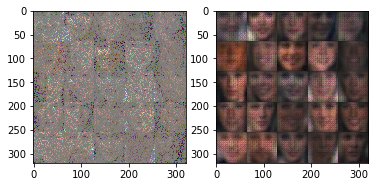

EPO: 1, dis_loss: 0.30592, en_loss: 0.23139, temp_en_dis: 10.26196 recon_loss: 0.0576
EPO: 1, dis_loss: 0.30384, en_loss: 0.21091, temp_en_dis: 10.72103 recon_loss: 0.0626
EPO: 1, dis_loss: 0.36439, en_loss: 0.21265, temp_en_dis: 10.24485 recon_loss: 0.0673
EPO: 1, dis_loss: 0.30124, en_loss: 0.23098, temp_en_dis: 10.53911 recon_loss: 0.0559
EPO: 1, dis_loss: 0.38283, en_loss: 0.21995, temp_en_dis: 10.50956 recon_loss: 0.0616
EPO: 1, dis_loss: 0.31572, en_loss: 0.20773, temp_en_dis: 9.33531 recon_loss: 0.0656
EPO: 1, dis_loss: 0.31276, en_loss: 0.23635, temp_en_dis: 10.74818 recon_loss: 0.0623
EPO: 1, dis_loss: 0.31007, en_loss: 0.26175, temp_en_dis: 10.26350 recon_loss: 0.0601
EPO: 1, dis_loss: 0.31360, en_loss: 0.25165, temp_en_dis: 10.65264 recon_loss: 0.0569
EPO: 1, dis_loss: 0.30477, en_loss: 0.22814, temp_en_dis: 10.25120 recon_loss: 0.0641
######### what? the reconstruction psnr is: 13.7841


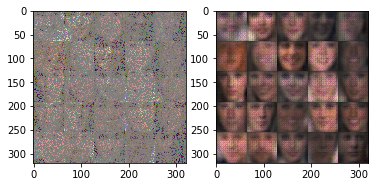

EPO: 1, dis_loss: 0.30595, en_loss: 0.27570, temp_en_dis: 10.49249 recon_loss: 0.0563
EPO: 1, dis_loss: 0.27775, en_loss: 0.24586, temp_en_dis: 9.86743 recon_loss: 0.0621
EPO: 1, dis_loss: 0.25665, en_loss: 0.25960, temp_en_dis: 9.67309 recon_loss: 0.0636
EPO: 1, dis_loss: 0.37302, en_loss: 0.24833, temp_en_dis: 9.41746 recon_loss: 0.0605
EPO: 1, dis_loss: 0.37079, en_loss: 0.23154, temp_en_dis: 11.04520 recon_loss: 0.0636
EPO: 1, dis_loss: 0.30720, en_loss: 0.25070, temp_en_dis: 9.24914 recon_loss: 0.0593
EPO: 1, dis_loss: 0.27467, en_loss: 0.26599, temp_en_dis: 9.80655 recon_loss: 0.0606
EPO: 1, dis_loss: 0.37300, en_loss: 0.25243, temp_en_dis: 10.52565 recon_loss: 0.0616
EPO: 1, dis_loss: 0.42720, en_loss: 0.24831, temp_en_dis: 10.91092 recon_loss: 0.0601
EPO: 1, dis_loss: 0.34371, en_loss: 0.25562, temp_en_dis: 10.42585 recon_loss: 0.0598
######### what? the reconstruction psnr is: 13.8323


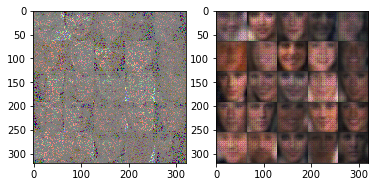

EPO: 1, dis_loss: 0.31946, en_loss: 0.22804, temp_en_dis: 9.76164 recon_loss: 0.0616
EPO: 1, dis_loss: 0.31895, en_loss: 0.21981, temp_en_dis: 9.92610 recon_loss: 0.0615
EPO: 2, dis_loss: 0.27964, en_loss: 0.23438, temp_en_dis: 10.85322 recon_loss: 0.0622
EPO: 2, dis_loss: 0.28276, en_loss: 0.26694, temp_en_dis: 10.50166 recon_loss: 0.0596
EPO: 2, dis_loss: 0.29334, en_loss: 0.22788, temp_en_dis: 9.44361 recon_loss: 0.0619
EPO: 2, dis_loss: 0.42100, en_loss: 0.24571, temp_en_dis: 10.62790 recon_loss: 0.0612
EPO: 2, dis_loss: 0.36533, en_loss: 0.20932, temp_en_dis: 9.46142 recon_loss: 0.0579
EPO: 2, dis_loss: 0.37395, en_loss: 0.21972, temp_en_dis: 10.28726 recon_loss: 0.0630
EPO: 2, dis_loss: 0.33934, en_loss: 0.22804, temp_en_dis: 10.06243 recon_loss: 0.0619
EPO: 2, dis_loss: 0.31350, en_loss: 0.23218, temp_en_dis: 10.10047 recon_loss: 0.0647
######### what? the reconstruction psnr is: 13.8394


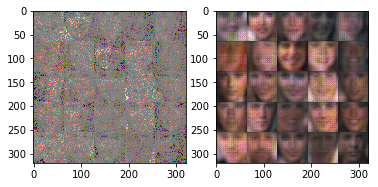

EPO: 2, dis_loss: 0.35549, en_loss: 0.22639, temp_en_dis: 10.64037 recon_loss: 0.0620
EPO: 2, dis_loss: 0.40759, en_loss: 0.23310, temp_en_dis: 10.18038 recon_loss: 0.0632
EPO: 2, dis_loss: 0.31541, en_loss: 0.24921, temp_en_dis: 9.66064 recon_loss: 0.0593
EPO: 2, dis_loss: 0.33766, en_loss: 0.23159, temp_en_dis: 10.29192 recon_loss: 0.0562
EPO: 2, dis_loss: 0.34324, en_loss: 0.25161, temp_en_dis: 10.27858 recon_loss: 0.0631
EPO: 2, dis_loss: 0.35410, en_loss: 0.24576, temp_en_dis: 10.02391 recon_loss: 0.0599
EPO: 2, dis_loss: 0.30285, en_loss: 0.26175, temp_en_dis: 10.18323 recon_loss: 0.0566
EPO: 2, dis_loss: 0.33587, en_loss: 0.22269, temp_en_dis: 10.85868 recon_loss: 0.0624
EPO: 2, dis_loss: 0.34899, en_loss: 0.21525, temp_en_dis: 10.29639 recon_loss: 0.0588
EPO: 2, dis_loss: 0.34183, en_loss: 0.23670, temp_en_dis: 10.23038 recon_loss: 0.0600
######### what? the reconstruction psnr is: 13.9413


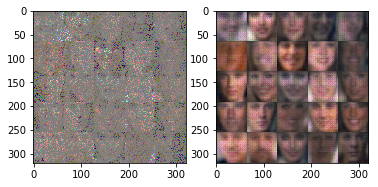

EPO: 2, dis_loss: 0.31363, en_loss: 0.23581, temp_en_dis: 9.91371 recon_loss: 0.0570
EPO: 2, dis_loss: 0.28219, en_loss: 0.22329, temp_en_dis: 10.13052 recon_loss: 0.0583
EPO: 2, dis_loss: 0.33316, en_loss: 0.25377, temp_en_dis: 9.96905 recon_loss: 0.0619
EPO: 2, dis_loss: 0.31440, en_loss: 0.23632, temp_en_dis: 10.32173 recon_loss: 0.0622
EPO: 2, dis_loss: 0.39142, en_loss: 0.23268, temp_en_dis: 10.12098 recon_loss: 0.0622
EPO: 2, dis_loss: 0.35029, en_loss: 0.23049, temp_en_dis: 9.99626 recon_loss: 0.0628
EPO: 2, dis_loss: 0.31178, en_loss: 0.22962, temp_en_dis: 10.03690 recon_loss: 0.0595
EPO: 2, dis_loss: 0.39085, en_loss: 0.22843, temp_en_dis: 10.31848 recon_loss: 0.0632
EPO: 2, dis_loss: 0.39505, en_loss: 0.22916, temp_en_dis: 9.63899 recon_loss: 0.0620
EPO: 2, dis_loss: 0.29730, en_loss: 0.23688, temp_en_dis: 9.53738 recon_loss: 0.0624
######### what? the reconstruction psnr is: 13.7276


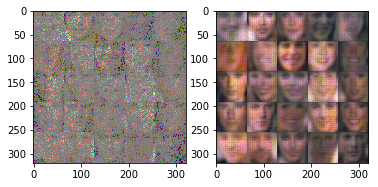

EPO: 2, dis_loss: 0.29387, en_loss: 0.24392, temp_en_dis: 9.56160 recon_loss: 0.0627
EPO: 2, dis_loss: 0.36715, en_loss: 0.23630, temp_en_dis: 10.46606 recon_loss: 0.0628
EPO: 2, dis_loss: 0.31673, en_loss: 0.24326, temp_en_dis: 9.39200 recon_loss: 0.0621
EPO: 3, dis_loss: 0.38309, en_loss: 0.22641, temp_en_dis: 9.51325 recon_loss: 0.0626
EPO: 3, dis_loss: 0.35225, en_loss: 0.25213, temp_en_dis: 9.79754 recon_loss: 0.0651
EPO: 3, dis_loss: 0.29765, en_loss: 0.22587, temp_en_dis: 10.83332 recon_loss: 0.0595
EPO: 3, dis_loss: 0.25767, en_loss: 0.20872, temp_en_dis: 10.07010 recon_loss: 0.0614
EPO: 3, dis_loss: 0.29029, en_loss: 0.23280, temp_en_dis: 10.01972 recon_loss: 0.0591
EPO: 3, dis_loss: 0.37800, en_loss: 0.21472, temp_en_dis: 10.43482 recon_loss: 0.0616
EPO: 3, dis_loss: 0.26743, en_loss: 0.25086, temp_en_dis: 10.41126 recon_loss: 0.0600
######### what? the reconstruction psnr is: 13.7476


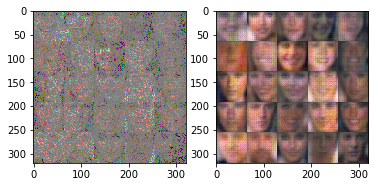

EPO: 3, dis_loss: 0.39296, en_loss: 0.24169, temp_en_dis: 10.33898 recon_loss: 0.0593
EPO: 3, dis_loss: 0.38419, en_loss: 0.23378, temp_en_dis: 9.71189 recon_loss: 0.0633
EPO: 3, dis_loss: 0.36039, en_loss: 0.24047, temp_en_dis: 9.65667 recon_loss: 0.0588
EPO: 3, dis_loss: 0.33966, en_loss: 0.24126, temp_en_dis: 10.38508 recon_loss: 0.0592
EPO: 3, dis_loss: 0.34518, en_loss: 0.24502, temp_en_dis: 9.67315 recon_loss: 0.0620
EPO: 3, dis_loss: 0.39607, en_loss: 0.23716, temp_en_dis: 10.23507 recon_loss: 0.0586
EPO: 3, dis_loss: 0.27984, en_loss: 0.25762, temp_en_dis: 10.02588 recon_loss: 0.0612
EPO: 3, dis_loss: 0.40300, en_loss: 0.24414, temp_en_dis: 10.50167 recon_loss: 0.0600
EPO: 3, dis_loss: 0.41529, en_loss: 0.24206, temp_en_dis: 10.48929 recon_loss: 0.0615
EPO: 3, dis_loss: 0.35179, en_loss: 0.25318, temp_en_dis: 10.00223 recon_loss: 0.0622
######### what? the reconstruction psnr is: 13.9941


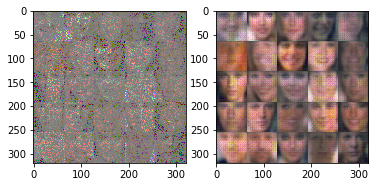

EPO: 3, dis_loss: 0.36113, en_loss: 0.23676, temp_en_dis: 9.77614 recon_loss: 0.0598
EPO: 3, dis_loss: 0.29945, en_loss: 0.25552, temp_en_dis: 10.27301 recon_loss: 0.0602
EPO: 3, dis_loss: 0.37231, en_loss: 0.24941, temp_en_dis: 10.01834 recon_loss: 0.0618
EPO: 3, dis_loss: 0.31361, en_loss: 0.23181, temp_en_dis: 9.81010 recon_loss: 0.0588
EPO: 3, dis_loss: 0.30164, en_loss: 0.23093, temp_en_dis: 10.19927 recon_loss: 0.0629
EPO: 3, dis_loss: 0.37009, en_loss: 0.27629, temp_en_dis: 10.31785 recon_loss: 0.0632
EPO: 3, dis_loss: 0.28641, en_loss: 0.23945, temp_en_dis: 9.80251 recon_loss: 0.0573
EPO: 3, dis_loss: 0.26868, en_loss: 0.21763, temp_en_dis: 10.33169 recon_loss: 0.0625
EPO: 3, dis_loss: 0.37314, en_loss: 0.27804, temp_en_dis: 11.00696 recon_loss: 0.0616
EPO: 3, dis_loss: 0.31434, en_loss: 0.27404, temp_en_dis: 10.06280 recon_loss: 0.0598
######### what? the reconstruction psnr is: 13.4994


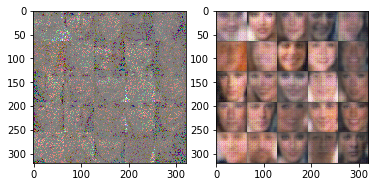

EPO: 3, dis_loss: 0.36400, en_loss: 0.27881, temp_en_dis: 9.56507 recon_loss: 0.0679
EPO: 3, dis_loss: 0.30836, en_loss: 0.24285, temp_en_dis: 9.73545 recon_loss: 0.0612
EPO: 3, dis_loss: 0.39767, en_loss: 0.24073, temp_en_dis: 9.89301 recon_loss: 0.0631
EPO: 3, dis_loss: 0.30038, en_loss: 0.24636, temp_en_dis: 10.31738 recon_loss: 0.0604
EPO: 4, dis_loss: 0.38567, en_loss: 0.25423, temp_en_dis: 9.79733 recon_loss: 0.0574
EPO: 4, dis_loss: 0.40986, en_loss: 0.24633, temp_en_dis: 10.54883 recon_loss: 0.0626
EPO: 4, dis_loss: 0.40225, en_loss: 0.26408, temp_en_dis: 9.99756 recon_loss: 0.0599
EPO: 4, dis_loss: 0.33938, en_loss: 0.24720, temp_en_dis: 10.00260 recon_loss: 0.0601
EPO: 4, dis_loss: 0.36867, en_loss: 0.26745, temp_en_dis: 10.45542 recon_loss: 0.0631
EPO: 4, dis_loss: 0.35039, en_loss: 0.24304, temp_en_dis: 10.13307 recon_loss: 0.0636
######### what? the reconstruction psnr is: 13.4183


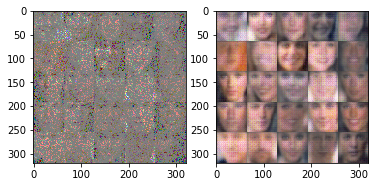

EPO: 4, dis_loss: 0.26623, en_loss: 0.25812, temp_en_dis: 10.28097 recon_loss: 0.0583
EPO: 4, dis_loss: 0.37032, en_loss: 0.20176, temp_en_dis: 10.13616 recon_loss: 0.0598
EPO: 4, dis_loss: 0.35520, en_loss: 0.23250, temp_en_dis: 10.44371 recon_loss: 0.0613
EPO: 4, dis_loss: 0.27416, en_loss: 0.25036, temp_en_dis: 10.24079 recon_loss: 0.0611
EPO: 4, dis_loss: 0.29884, en_loss: 0.26932, temp_en_dis: 9.95549 recon_loss: 0.0638
EPO: 4, dis_loss: 0.31574, en_loss: 0.30237, temp_en_dis: 9.62248 recon_loss: 0.0673
EPO: 4, dis_loss: 0.37658, en_loss: 0.25672, temp_en_dis: 10.19632 recon_loss: 0.0647
EPO: 4, dis_loss: 0.25874, en_loss: 0.26287, temp_en_dis: 9.47640 recon_loss: 0.0604
EPO: 4, dis_loss: 0.30315, en_loss: 0.22560, temp_en_dis: 10.37967 recon_loss: 0.0598
EPO: 4, dis_loss: 0.37228, en_loss: 0.27534, temp_en_dis: 10.26266 recon_loss: 0.0623
######### what? the reconstruction psnr is: 13.0619


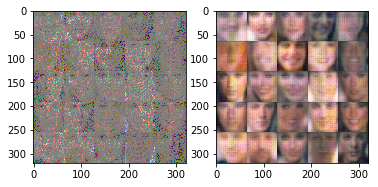

EPO: 4, dis_loss: 0.29041, en_loss: 0.24158, temp_en_dis: 9.61982 recon_loss: 0.0633
EPO: 4, dis_loss: 0.34023, en_loss: 0.24805, temp_en_dis: 9.78185 recon_loss: 0.0620
EPO: 4, dis_loss: 0.40021, en_loss: 0.26093, temp_en_dis: 9.83475 recon_loss: 0.0602
EPO: 4, dis_loss: 0.39657, en_loss: 0.25515, temp_en_dis: 10.87171 recon_loss: 0.0611
EPO: 4, dis_loss: 0.32047, en_loss: 0.24760, temp_en_dis: 10.29234 recon_loss: 0.0589
EPO: 4, dis_loss: 0.25354, en_loss: 0.26959, temp_en_dis: 10.18527 recon_loss: 0.0644
EPO: 4, dis_loss: 0.31298, en_loss: 0.28734, temp_en_dis: 9.40175 recon_loss: 0.0627
EPO: 4, dis_loss: 0.36152, en_loss: 0.22960, temp_en_dis: 9.78388 recon_loss: 0.0637
EPO: 4, dis_loss: 0.32837, en_loss: 0.23717, temp_en_dis: 9.92253 recon_loss: 0.0634
EPO: 4, dis_loss: 0.31792, en_loss: 0.25779, temp_en_dis: 10.86538 recon_loss: 0.0628
######### what? the reconstruction psnr is: 13.5278


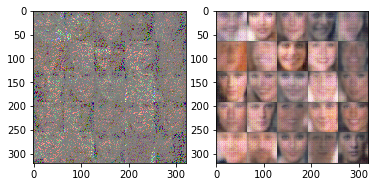

EPO: 4, dis_loss: 0.24996, en_loss: 0.24828, temp_en_dis: 10.51269 recon_loss: 0.0606
EPO: 4, dis_loss: 0.34890, en_loss: 0.24070, temp_en_dis: 10.36461 recon_loss: 0.0640
EPO: 4, dis_loss: 0.37784, en_loss: 0.23632, temp_en_dis: 10.69566 recon_loss: 0.0594
EPO: 4, dis_loss: 0.32617, en_loss: 0.27399, temp_en_dis: 9.94483 recon_loss: 0.0636
EPO: 4, dis_loss: 0.27348, en_loss: 0.24626, temp_en_dis: 10.52804 recon_loss: 0.0607
EPO: 4, dis_loss: 0.36467, en_loss: 0.26131, temp_en_dis: 10.23236 recon_loss: 0.0620
EPO: 5, dis_loss: 0.29986, en_loss: 0.25792, temp_en_dis: 10.25067 recon_loss: 0.0613
EPO: 5, dis_loss: 0.38393, en_loss: 0.27762, temp_en_dis: 9.82201 recon_loss: 0.0621
EPO: 5, dis_loss: 0.28867, en_loss: 0.26582, temp_en_dis: 10.31087 recon_loss: 0.0608
EPO: 5, dis_loss: 0.35690, en_loss: 0.24743, temp_en_dis: 10.59181 recon_loss: 0.0609
######### what? the reconstruction psnr is: 12.6875


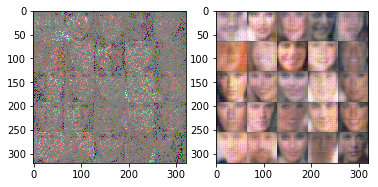

EPO: 5, dis_loss: 0.32729, en_loss: 0.29445, temp_en_dis: 9.83475 recon_loss: 0.0633
EPO: 5, dis_loss: 0.36889, en_loss: 0.25386, temp_en_dis: 10.27118 recon_loss: 0.0605
EPO: 5, dis_loss: 0.34608, en_loss: 0.26558, temp_en_dis: 10.37557 recon_loss: 0.0618
EPO: 5, dis_loss: 0.39839, en_loss: 0.29006, temp_en_dis: 10.30727 recon_loss: 0.0664
EPO: 5, dis_loss: 0.28383, en_loss: 0.26860, temp_en_dis: 9.74430 recon_loss: 0.0620
EPO: 5, dis_loss: 0.36177, en_loss: 0.25422, temp_en_dis: 10.57026 recon_loss: 0.0576
EPO: 5, dis_loss: 0.35276, en_loss: 0.24320, temp_en_dis: 10.26222 recon_loss: 0.0598
EPO: 5, dis_loss: 0.33148, en_loss: 0.27075, temp_en_dis: 9.78264 recon_loss: 0.0607
EPO: 5, dis_loss: 0.32882, en_loss: 0.28581, temp_en_dis: 9.68489 recon_loss: 0.0604
EPO: 5, dis_loss: 0.34184, en_loss: 0.28102, temp_en_dis: 9.94668 recon_loss: 0.0620
######### what? the reconstruction psnr is: 13.3628


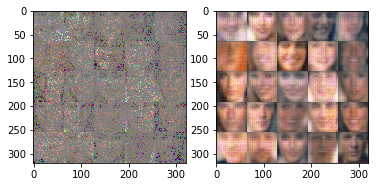

EPO: 5, dis_loss: 0.35676, en_loss: 0.26734, temp_en_dis: 10.08083 recon_loss: 0.0615
EPO: 5, dis_loss: 0.28960, en_loss: 0.29463, temp_en_dis: 9.29675 recon_loss: 0.0613
EPO: 5, dis_loss: 0.33910, en_loss: 0.28001, temp_en_dis: 10.08379 recon_loss: 0.0602
EPO: 5, dis_loss: 0.32969, en_loss: 0.26118, temp_en_dis: 10.22172 recon_loss: 0.0612
EPO: 5, dis_loss: 0.35066, en_loss: 0.25661, temp_en_dis: 10.11524 recon_loss: 0.0607
EPO: 5, dis_loss: 0.33397, en_loss: 0.28662, temp_en_dis: 10.09034 recon_loss: 0.0584
EPO: 5, dis_loss: 0.30048, en_loss: 0.26000, temp_en_dis: 9.92097 recon_loss: 0.0620
EPO: 5, dis_loss: 0.44010, en_loss: 0.25759, temp_en_dis: 10.19070 recon_loss: 0.0629
EPO: 5, dis_loss: 0.31198, en_loss: 0.25421, temp_en_dis: 10.35405 recon_loss: 0.0621
EPO: 5, dis_loss: 0.33154, en_loss: 0.28490, temp_en_dis: 9.69069 recon_loss: 0.0588
######### what? the reconstruction psnr is: 12.9136


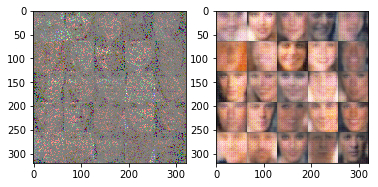

EPO: 5, dis_loss: 0.29500, en_loss: 0.28458, temp_en_dis: 9.58652 recon_loss: 0.0638
EPO: 5, dis_loss: 0.37142, en_loss: 0.27469, temp_en_dis: 9.50988 recon_loss: 0.0603
EPO: 5, dis_loss: 0.40441, en_loss: 0.27726, temp_en_dis: 10.15043 recon_loss: 0.0625
EPO: 5, dis_loss: 0.35645, en_loss: 0.26095, temp_en_dis: 10.32956 recon_loss: 0.0612
EPO: 5, dis_loss: 0.30835, en_loss: 0.27475, temp_en_dis: 9.75348 recon_loss: 0.0599


In [ ]:
batch_size = 32
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.9
M = 5
z_dim = 100
tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10
sample_set = helper.Dataset('uiuc_celeba', glob(os.path.join(data_dir, 'test/*.png'))[:25])
sample_images = next(sample_set.get_batches(25))

sample_images *= 2

celeba_dataset = helper.Dataset('uiuc_celeba', glob(os.path.join(data_dir, 'aligned/*.png'))[25:10025])
print(celeba_dataset.shape)


with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, beta2, M, celeba_dataset.get_batches, 
         sample_images, celeba_dataset.shape, celeba_dataset.image_mode)





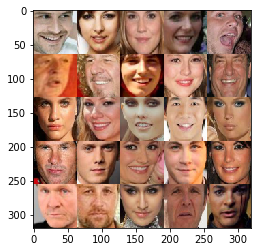

In [42]:
#tempimages = next(celeba_dataset.get_batches(25))
pyplot.imshow(helper.images_square_grid(sample_images, 'RGB'))

## Validation on 2000 images

(25, 64, 64, 3)
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ./UIUC_plus_checkpoint/AntiUIUCplus.model-3000

            We found a existing model and continue to train on it! 
            If you need a new model, delete checkpoint directory
Some psnr value is : 21.1291


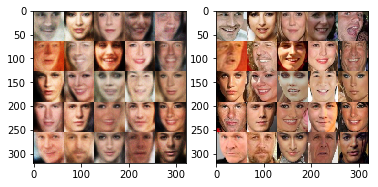

Testing on validation set average psnr: 17.6025
Testing on original set average psnr: 21.1291


In [29]:
batch_size = 25
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.9
z_dim = 100

test_set = helper.Dataset('uiuc_celeba', glob(os.path.join(data_dir, 'test/*.png'))[:25])
pixFrac = 0.2
mask = np.random.binomial(1, pixFrac, IMAGE_SHAPE)

print(test_set.shape)

with tf.Graph().as_default():
    psnrs = test(batch_size, z_dim, learning_rate, beta1, beta2, mask, 
        test_set.get_batches, test_set.shape, test_set.image_mode)


In [33]:
print(max(psnrs))

13.0508566926
